# Self-Driving Car Engineer Nanodegree


## Project 3: Behavioral Cloning
August 2017


---

## Goal
The goal of this project is to build a machine learning model that can successfully steer a car around a race track that it's never encountered before.

The details for this project are located here at [Udacity's Github repo](https://github.com/udacity/CarND-Behavioral-Cloning-P3). My implementation of the project can be found [here at my Github repo](https://github.com/tommytracey/udacity/tree/master/self-driving-nano/projects/3-behavioral-cloning).


---
## Initial Setup

#### Import Modules

In [1]:
import csv
# import cv2
import keras
import keras.backend
from keras.callbacks import ModelCheckpoint, Callback
from keras.layers.core import Activation, Dense, Dropout, Flatten, Lambda, Reshape
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.models import Sequential, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf

Using TensorFlow backend.


#### Verify that Keras is using Tensforflow backend

The Keras backend uses Theano by default and changing it to Tensorflow can be tricky via Jupyter. Simply updating the config json file `$HOME/.keras/keras.json` as directed in [Keras backend documentation](https://keras.io/backend/) did not work for me. Trying to set it _before or after loading the notebook_ did not work eithter when using:

`$ os.environ["KERAS_BACKEND"]="tensorflow"`

The only way I could reliably set Tensorflow as the backend was to use the following command **UPON loading the notebook**:

`$ KERAS_BACKEND=tensorflow jupyter notebook`

(NOTE: You can also append `--NotebookApp.iopub_data_rate_limit=10000000000` to the above command if your notebook includes a lot of visualizations. This will help prevent the kernel from crashing and/or causing you to lose your connection to your AWS EC2 instance.)

Re: the backend, **the cell below only provides a sanity check that the backend is configured as expected**. Note that the version of Tensorflow being used by Keras may be different than the one you typically run in your environment. 

[This post](https://www.nodalpoint.com/switch-keras-backend/) by Christos-Iraklis Tsatsoulis provides even more detail if you'd like to further understand the issues and automate the setup process.

In [2]:
print('Keras version: ', keras.__version__)
print('Tensorflow version: ', tf.__version__)
print('Keras backend: ', keras.backend.backend())
print('keras.backend.image_dim_ordering = ', keras.backend.image_dim_ordering())

os.environ["KERAS_BACKEND"] = "tensorflow"
if keras.backend.backend() != 'tensorflow':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('tf')
    print("\nBackend OK")

Keras version:  2.0.6
Tensorflow version:  1.2.1
Keras backend:  tensorflow
keras.backend.image_dim_ordering =  tf

Backend OK


---
## Step 1: Load and preview the data

In [3]:
## Load data from .csv and preview it in Pandas dataframe

with open('data/udacity/driving_log.csv', newline='') as f:
    udacity_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))

columns = udacity_data[0]
udacity_df = pd.read_csv('data/udacity/driving_log.csv', skiprows=[0], names=columns)

print('total rows: ', len(udacity_df))
udacity_df.head()

total rows:  8036


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


#### Data Set: Initial Observations
We can see from the table above that the driving data includes:
- relative paths to .jpg images from three different camera angles (center, left, right)
- floating point measurements of the vehicle's steering angle, throttle, brake, and speed
- the data appears to be time series, although no time stamps are included

### Preview the driving images

The driving images are the training features for our model. 

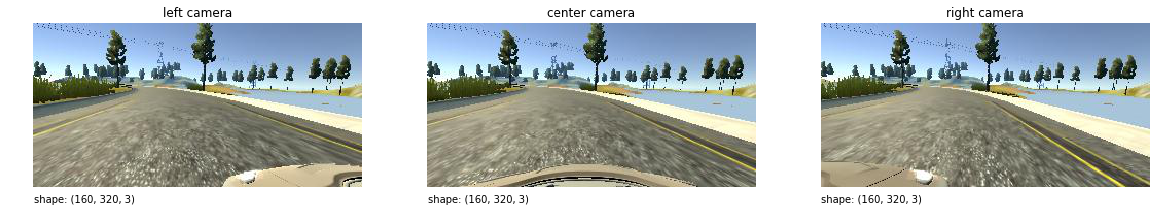

In [64]:
## Preview a random set of images from each camera angle

# Display visualizations in the notebook
%matplotlib inline

index = random.randint(0, len(udacity_data))
img_dir = 'data/udacity/'

center_img_orig = mpimg.imread(img_dir + udacity_data[index][0])
left_img_orig = mpimg.imread(img_dir + udacity_data[index][1])
right_img_orig = mpimg.imread(img_dir + udacity_data[index][2])

plt.figure(figsize=(20,5))

plt.subplot2grid((1, 3), (0, 0));
plt.axis('off')
plt.title('left camera')
plt.text(0, left_img_orig.shape[0]+15, ('shape: ' + str(left_img_orig.shape)))
plt.imshow(left_img_orig, cmap="gray")

plt.subplot2grid((1, 3), (0, 1));
plt.axis('off')
plt.title('center camera')
plt.text(0, center_img_orig.shape[0]+15, ('shape: ' + str(center_img_orig.shape)))
plt.imshow(center_img_orig, cmap="gray")

plt.subplot2grid((1, 3), (0, 2));
plt.axis('off')
plt.title('right camera')
plt.text(0, right_img_orig.shape[0]+15, ('shape: ' + str(right_img_orig.shape)))
plt.imshow(right_img_orig, cmap="gray")

#### Driving Images: Initial Observations
We can see from the images above that:
- the images are taken in the front of the car (no side or rear angles)
- each image is 160x320 with 3 RGB color channels
- there is quite a bit of superfluous data, i.e. data that won't benefit the model; for example the sky, hills, trees in the background, as well as the hood of the car).

If you view enough images or actually run the simulator, you also see that:
- there are a lot of turns in the road (duh!), but since the track ultimately ends where it started, there seems to be more turns in one direction than the other
- the lane markings change shape and color at different points in the track, and at some points there are no markings at all!
- all of the images are consistently bright; no glare, no darkness, and no shadows that you'd usually encounter with normal driving

Given the simulation takes place on a race track (not a highway), the road is free of additional cars, traffic signs, lanes, etc. We won't account for these in this project, but a more robust driving model would need training data that included these conditions. 

That said, many of the other items above can create biases in our model and cause it to overfit the specific driving conditions within this particular simulation. We need to correct for these so that our model learns to drive in a variety of conditions we might find on other tracks. We'll do this by pre-processing and augmenting our training data throughout the sections to follow. But first let's look at our target data (steering angles) to see if there's anything else we need to correct for. 

### Examine the steering angles
The steering angles are our target data for training the model. That is, based on the images fed into the model while the car is driving along the track, the model will predict the appropriate steering angle to navigate the patch of road ahead.

#### Distribution

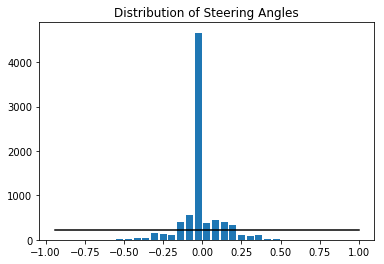

In [35]:
%matplotlib inline

angles = udacity_df.steering.tolist()
num_bins = 35
avg_per_bin = len(angles) / num_bins

hist, bins = np.histogram(angles, num_bins)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.title('Distribution of Steering Angles')
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_per_bin, avg_per_bin), 'k-')
plt.show()

**Steering Angle Observations**:

We can see from the graph above that an overwhelming amount of the target data are steering angles close to zero (i.e., when the car is driving straight). This biases our model to drive the car straight and make it's difficult to learn how to navigate turns. 

It also seems there may be an imbalance in left vs. right turning data (although not as much as I had expected). It's not clear how big of an impact this would have on the model, but there's a chance the model could learn to turn more effectively in one direction than the other. Just to be safe we'll correct for this by ensuring there are equal quantities of left and right steering data after pre-processing. 

---
## Step 2: Data pre-processing

**Data Sources**: 
- There are two tracks, but all of the original training and validation data is generated by driving the simulator on **Track 1**.
- Udacity provides an intial set of "good" data to get us started.
- Additional data is gathered by running the simulator myself. 

**Training Data**:
- The training data set includes the original image data captured from the simulator on Track 1, plus any additional data generated via pre-processing and augmentation. 

**Validation Data**:
- The validation data will contain the original image data captured from the simulator on Track 1, with only a pre-process to create a more balanced distribution (i.e., reduce the 'drive straight' bias). No other pre-processing or augmentation is included. This ensures we can properly validate whether changes we're making to the model or training data are increasing or decreasing the model's performance. 

**Test Data**:
- We'll test the model's ability to generalize by running it on **Track 2**. So, the simulator input images from Track 2 will serve as our test data.

### 2.1 Reduce the amount of "drive straight" data

In [4]:
steer_thresh = 0.15   # the +/- degrees from center that determine a left or right turn
steer_correct = 0.25  # the steering angle correction applied to left and right camera angles

In [21]:
udacity_pp = udacity_data[1:]   # create copy of data for pre-processing

# column references: 0=center_img, 1=left_img, 2=right_img, 3=steering, 4=throttle, 5=brake, 6=speed

udacity_norm = []

for row in udacity_pp:
    # add right turns
    if float(row[3]) > steer_thresh:
        udacity_norm.append(row)
    # add left turns
    elif float(row[3]) < -steer_thresh:
        udacity_norm.append(row)
    # randomly select a subset of straight turns
    else:
        if random.randint(0, 3) == 1:
            udacity_norm.append(row)


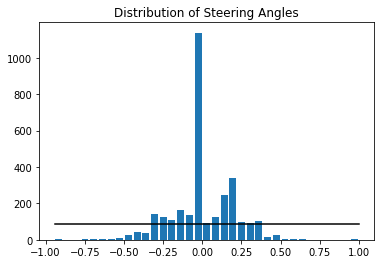

In [22]:
%matplotlib inline

angles = [float(row[3]) for row in udacity_norm]
num_bins = 35
avg_per_bin = len(angles) / num_bins

hist, bins = np.histogram(angles, num_bins)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.title('Distribution of Steering Angles')
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_per_bin, avg_per_bin), 'k-')
plt.show()

### 2.2 Add left and right camera data

In [39]:
udacity_pp = udacity_data[1:]   # create copy of data for pre-processing

# column references: 0=center_img, 1=left_img, 2=right_img, 3=steering, 4=throttle, 5=brake, 6=speed

# gather image and angle data for all 3 cameras, with correction for left and right
center = [(row[0], float(row[3])) for row in udacity_pp]
left = [(row[1], float(row[3])+steer_correct) for row in udacity_pp]
right = [(row[2], float(row[3])-steer_correct) for row in udacity_pp]

udacity_3cam = center + left + right


In [40]:
len(udacity_3cam)

24108

### 2.3 Crop

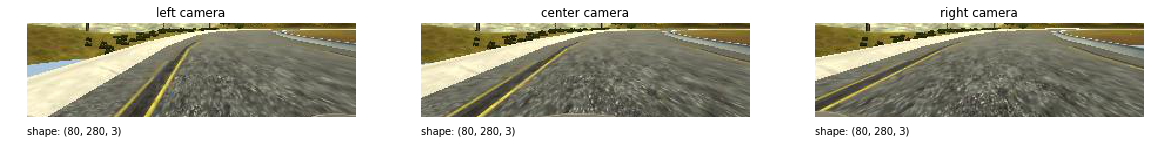

In [65]:
## Preview a random set of images from each camera angle

# Display visualizations in the notebook
%matplotlib inline

index = random.randint(0, len(udacity_data))
img_dir = 'data/udacity/'

# crop dimensions
h1, h2 = (60, 140)
w1, w2 = (20, 300)

center_img_crop = mpimg.imread(img_dir + udacity_data[index][0])[h1:h2,w1:w2]
left_img_crop = mpimg.imread(img_dir + udacity_data[index][1])[h1:h2,w1:w2]
right_img_crop = mpimg.imread(img_dir + udacity_data[index][2])[h1:h2,w1:w2]

plt.figure(figsize=(20,5))

plt.subplot2grid((1, 3), (0, 0));
plt.axis('off')
plt.title('left camera')
plt.text(0, left_img_crop.shape[0]+15, ('shape: ' + str(left_img_crop.shape)))
plt.imshow(left_img_crop, cmap="gray")

plt.subplot2grid((1, 3), (0, 1));
plt.axis('off')
plt.title('center camera')
plt.text(0, center_img_crop.shape[0]+15, ('shape: ' + str(center_img_crop.shape)))
plt.imshow(center_img_crop, cmap="gray")

plt.subplot2grid((1, 3), (0, 2));
plt.axis('off')
plt.title('right camera')
plt.text(0, right_img_crop.shape[0]+15, ('shape: ' + str(right_img_crop.shape)))
plt.imshow(right_img_crop, cmap="gray")

### Create training and validation sets


In [ ]:
## Include all camera angles

# From Udacity

# Self-generated

# Combined

In [23]:
## Create training and validation sets *REDUCE CENTER SAMPLES*

X_train = [row[0] for row in udacity_norm]
y_train = [float(row[3]) for row in udacity_norm]

X_train, X_valid, y_train, y_valid = \
                train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [27]:
## Create training and validation sets *ORIGINAL, CENTER ONLY*

X_train = [row[0] for row in udacity_pp]
y_train = [float(row[3]) for row in udacity_pp]

X_train, X_valid, y_train, y_valid = \
                train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [42]:
## Create training and validation sets *3CAM*

X_train = [i[0] for i in udacity_3cam]
y_train = [i[1] for i in udacity_3cam]

X_train, X_valid, y_train, y_valid = \
                train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [79]:
udacity_3cam[0:10]

[('IMG/center_2016_12_01_13_30_48_287.jpg', 0.0),
 ('IMG/center_2016_12_01_13_30_48_404.jpg', 0.0),
 ('IMG/center_2016_12_01_13_31_12_937.jpg', 0.0),
 ('IMG/center_2016_12_01_13_31_13_037.jpg', 0.0),
 ('IMG/center_2016_12_01_13_31_13_177.jpg', 0.0),
 ('IMG/center_2016_12_01_13_31_13_279.jpg', 0.0),
 ('IMG/center_2016_12_01_13_31_13_381.jpg', 0.0),
 ('IMG/center_2016_12_01_13_31_13_482.jpg', 0.0),
 ('IMG/center_2016_12_01_13_31_13_584.jpg', 0.0),
 ('IMG/center_2016_12_01_13_31_13_686.jpg', 0.0)]

In [23]:


# Group by steering angle

# Adjust steering angles for left and right cameras



### Augmentation of training data

## Affine transformations

# Flip horizontally

# Brightness
# HSA
# Shift
# Shear
# Color channels

# Shadows

# Create equal distribution


In [78]:

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_valid = len(X_valid)

# # TODO: Number of testing examples.
# n_test = len(X_test)

# # TODO: What's the shape of a traffic sign image?
# image_shape = X_train.shape[1:]

# # TODO: How many unique classes/labels there are in the dataset.
# labels_index = np.unique(y_train)
# n_labels = len(labels_index)

print("Number of training examples: ", n_train)
print("Number of validation examples: ", n_valid)
print("----------\nVerify Totals: {} should equal {} ".format((n_train+n_valid), len(udacity_3cam)))
# print("Number of testing examples =", n_test)
# print("Image data shape =", image_shape)
# print("Number of labels/classes =", n_labels)

Number of training examples:  19286
Number of validation examples:  4822
----------
Verify Totals: 24108 should equal 24108 


In [ ]:
# center = udacity_df.center.tolist()
# # left = data.left.tolist()
# # right = data.right.tolist()
# steering = udacity_df.steering.tolist()

---
### Augmentation

Generates batches of tensor image data that is augmented based on a chosen set of tranformation parameters (e.g. rotation, shift, shear, zoom).

In [ ]:
# ## Apply affine and color transformations 

# # Transformations applied to RBG training images *ORIGINAL from Project 2*
# datagen = keras.preprocessing.image.ImageDataGenerator(
#     zca_whitening=True,
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.15,
#     zoom_range=0.15,
#     channel_shift_range=0.1,
#     fill_mode='nearest',
#     horizontal_flip=False,
#     vertical_flip=False
# )


In [ ]:
# NEW augmenation function

datagen = keras.preprocessing.image.ImageDataGenerator(
    zca_whitening=True,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    channel_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=False
)


In [ ]:
## Create AUGMENTED training sets

from sklearn.utils import shuffle

max_images_per_class = 6000
X_train_aug = np.empty((0, 32, 32, 3))
y_train_aug = np.empty(0, dtype='uint8')

print('Augmenting Image Data...')
for i in tqdm(range(n_labels)):
    index = [y_train==i]
    i_class_images = X_train_norm[y_train==i]
    i_class_y = y_train[y_train==i]

    i_X_train_aug = np.copy(i_class_images)
    i_y_train_aug = np.copy(i_class_y)

    for X,y in datagen.flow(i_class_images, i_class_y, batch_size=len(i_class_y), seed=113+i*17):            
        i_X_train_aug = np.append(i_X_train_aug, X, axis=0)
        i_y_train_aug = np.append(i_y_train_aug, y, axis=0)

        if len(i_X_train_aug) >= max_images_per_class:
            break

    X_train_aug = np.append(X_train_aug, i_X_train_aug[:max_images_per_class], axis=0)
    y_train_aug = np.append(y_train_aug, i_y_train_aug[:max_images_per_class], axis=0)              

X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug, random_state=113)

print('Augmentation Complete.')



In [ ]:
print('new number of training images: ', X_train_aug.shape[0])
print('verify image shape: ', X_train_aug.shape[1:])

In [ ]:
## Display sample of the AUGMENTED training images, 1 image for each class

fig = plt.figure(figsize=(22,35), tight_layout={'h_pad':5})

for i in range(n_labels):
    image_key = np.where(y_train_aug==i)
    img = X_train_aug[image_key[0][0]]
    ax = fig.add_subplot(int(n_labels/4)+1,4,i+1) 
    ax.imshow(img, interpolation='none')
    plt.title("[%02d] %s" % (i, labels_dict[y_train_aug[image_key[0][0]]]))
    plt.axis('off')
plt.show()

In [ ]:
## Display a broader sample of AUGMENTED images, 12 from each class

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

images_labels = list(train_images_dict.keys())
for image_key in images_labels:        
    subplots = 12
    fig, axes = plt.subplots(1,subplots)
    images_total = len(train_images_dict[image_key])
    print('[{}] {}'.format(image_key, labels_dict[image_key]))
    offset = images_total // subplots
    images = [train_images_dict[image_key][j*offset] for j in range(subplots)]
    for i, (image, ax) in enumerate(zip(images, axes)):
        ax.imshow(image.squeeze())
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

train_images_dict.clear()

---
## Model Architecture
---

### Operations

### Generator

In [74]:
def generator(images, angles, val=True):
    images, angles = shuffle(images, angles)
    X = []  # images batch
    y = []  # angles batch
    while True:
        for i in range(len(angles)):
            img_path = IMG_DIR + images[i]
            image = mpimg.imread(img_path.strip())
            image = image[h1:h2,w1:w2]
            if not val:
                image = image  # add augmentation functions later
            X.append(image)
            y.append(angles[i])
            if len(y) == batch_size:
                yield (np.array(X), np.array(y))
                X, y = ([],[])
                images, angles = shuffle(images, angles)

### Model

In [75]:
## Global variables and parameters

LOG_DIR = ".logs"
MODEL_DIR = ".models"
IMG_DIR = "data/udacity/"

epochs = 10
batch_size = 128

mu = 0             # normalized mean
sigma = 0.1        # normalized stdev
lr = 1e-4          # learning rate
reg = l2(1e-5)     # L2 reg
drop = 0.5

strides = (2, 2)
act = 'relu'
default_pad = 'same'

orig_shape = center_img_orig.shape
crop_shape = center_img_crop.shape

In [76]:
model = Sequential()

model.add(Lambda(lambda x: x/255 - 0.5, input_shape=crop_shape))

model.add(Convolution2D(24, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Convolution2D(36, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Convolution2D(48, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Convolution2D(64, 3, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Convolution2D(64, 3, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())
model.add(Dense(80, kernel_regularizer=reg))
model.add(Dropout(drop))
model.add(Dense(40, kernel_regularizer=reg))
model.add(Dropout(drop))
model.add(Dense(16, kernel_regularizer=reg))
model.add(Dropout(drop))
model.add(Dense(10, kernel_regularizer=reg))
model.add(Dense(1))

# Compile and preview the model
model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 80, 280, 3)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 40, 140, 24)       1824      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 20, 70, 36)        21636     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 10, 35, 48)        43248     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 5, 18, 64)         27712     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 3, 9, 64)          36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1728)              0         
__________

In [80]:
## Train and save the model

train_gen = generator(X_train, y_train, val=False)
val_gen = generator(X_valid, y_valid, val=True)

train_steps = len(X_train) // batch_size
val_steps = len(X_valid) // batch_size

model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=epochs, \
                    validation_data=val_gen, validation_steps=val_steps)

print('\nDone Training')

# Save model and weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save("model.h5")
print("Saved model to disk")

Epoch 1/10
150/150 [==============================] - 41s - loss: 0.0213 - acc: 0.1831 - val_loss: 0.0158 - val_acc: 0.1791
Epoch 2/10
150/150 [==============================] - 41s - loss: 0.0200 - acc: 0.1828 - val_loss: 0.0167 - val_acc: 0.1862
Epoch 3/10
150/150 [==============================] - 41s - loss: 0.0197 - acc: 0.1782 - val_loss: 0.0150 - val_acc: 0.1723
Epoch 4/10
150/150 [==============================] - 41s - loss: 0.0194 - acc: 0.1840 - val_loss: 0.0154 - val_acc: 0.1759
Epoch 5/10
150/150 [==============================] - 41s - loss: 0.0187 - acc: 0.1781 - val_loss: 0.0146 - val_acc: 0.1698
Epoch 6/10
150/150 [==============================] - 41s - loss: 0.0179 - acc: 0.1823 - val_loss: 0.0151 - val_acc: 0.1769
Epoch 7/10
150/150 [==============================] - 41s - loss: 0.0174 - acc: 0.1812 - val_loss: 0.0141 - val_acc: 0.1824
Epoch 8/10
150/150 [==============================] - 41s - loss: 0.0176 - acc: 0.1784 - val_loss: 0.0134 - val_acc: 0.1765
Epoch 9/